# ICV Assignment #2
## 2016-13343 유상윤

Modules which will be used through this assignment

In [198]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math
import time

## Problem 1 Weighted Guassian Filter

### Functions for Weighted Guided Filter

In [185]:
def getGaussianFilter(r, sigma):
    size = 2*r+1
    kernel = np.fromfunction(lambda x, y: (1/(2*math.pi*sigma**2)) * math.e ** ((-1*((x-(size-1)/2)**2+(y-(size-1)/2)**2))/(2*sigma**2)), (size, size))
    return kernel

def filter2D(img, kernel):
    filtered_img = np.zeros(img.shape)
    r = int(kernel.shape[0]/2)
    pad_img = np.pad(img, r)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            filtered_img[i,j] = np.sum(np.multiply(kernel, pad_img[i:i+2*r+1, j:j+2*r+1]))
    return filtered_img

def f_mean(img, r, sig):
    rows, cols = img.shape[:2]
    kernel = getGaussianFilter(r, sig)
    return filter2D(img, kernel)

### Guided Filter Algorithm (for grayscale image)
followed the pseudo code in asssignment insturctions

In [186]:
def guided_filter(I, p, r, sig, eps):
    mean_I = f_mean(I, r, sig)
    mean_p = f_mean(p, r, sig)
    corr_I = f_mean(I*I, r, sig)
    corr_Ip = f_mean(I*p, r, sig)

    var_I = corr_I - mean_I*mean_I
    cov_Ip = corr_Ip - mean_I*mean_p

    a = cov_Ip/(var_I+eps)
    b = mean_p - a*mean_I

    mean_a = f_mean(a, r, sig)
    mean_b = f_mean(b, r, sig)

    q = mean_a*I + mean_b
    return q

### Guided Filter Algorithm (for rgb multichannel color image)

#### multichannel color image as guidance, single channel as input
followed the pseudo code in paper Guided Image Filtering, by Kaiming He

In [232]:
def guided_filter_color_guidance(I, p, r, sig, eps):
    I_r = I[:,:,0]
    I_g = I[:,:,1]
    I_b = I[:,:,2]

    mean_I_r = f_mean(I_r, r, sig)
    mean_I_g = f_mean(I_g, r, sig)
    mean_I_b = f_mean(I_b, r, sig)

    mean_p = f_mean(p, r, sig)

    corr_I_rr = f_mean(I_r*I_r, r, sig)
    corr_I_rg = f_mean(I_r*I_g, r, sig)
    corr_I_rb = f_mean(I_r*I_b, r, sig)
    corr_I_gg = f_mean(I_g*I_g, r, sig)
    corr_I_gb = f_mean(I_g*I_b, r, sig)
    corr_I_bb = f_mean(I_b*I_b, r, sig)

    corr_Ip_r = f_mean(I_r*p, r, sig)
    corr_Ip_g = f_mean(I_g*p, r, sig)
    corr_Ip_b = f_mean(I_b*p, r, sig)

    cov_Ip_r = corr_Ip_r - mean_I_r*mean_p
    cov_Ip_g = corr_Ip_g - mean_I_g*mean_p
    cov_Ip_b = corr_Ip_b - mean_I_b*mean_p

    var_I_rr = corr_I_rr - mean_I_r*mean_I_r
    var_I_rg = corr_I_rg - mean_I_r*mean_I_g
    var_I_rb = corr_I_rb - mean_I_r*mean_I_b
    var_I_gg = corr_I_gg - mean_I_g*mean_I_g
    var_I_gb = corr_I_gb - mean_I_g*mean_I_b
    var_I_bb = corr_I_bb - mean_I_b*mean_I_b

    a = np.zeros(I.shape)
    for x in range(a.shape[0]):
        for y in range(a.shape[1]):
            var_I = np.array([[var_I_rr[x][y], var_I_rg[x][y], var_I_rb[x][y]],
                    [var_I_rg[x][y], var_I_gg[x][y], var_I_gb[x][y]],
                    [var_I_rb[x][y], var_I_gb[x][y], var_I_bb[x][y]]])

            cov_Ip = [cov_Ip_r[x][y], cov_Ip_g[x][y], cov_Ip_b[x][y]]
            a[x][y] = np.matmul(cov_Ip, np.linalg.inv(var_I + eps*np.eye(3)))

    b = mean_p - (a[:,:,0]*mean_I_r + a[:,:,1]*mean_I_g + a[:,:,2]*mean_I_b)

    mean_a_r = f_mean(a[:,:,0], r, sig)
    mean_a_g = f_mean(a[:,:,1], r, sig)
    mean_a_b = f_mean(a[:,:,2], r, sig)

    mean_b = f_mean(b, r, sig)

    q = np.zeros(I.shape)

    q = mean_a_r*I_r + mean_a_g*I_g + mean_a_b*I_b + mean_b

    return q

#### multichannel color image as input ,single channel as guidance
followed the pseudo code in paper Guided Image Filtering, by Kaiming He

In [215]:
def guided_filter_color_input(I, p, r, sig, eps):
    q = np.zeros(p.shape)
    for i in range(p.shape[2]):
        q[:,:,i] = guided_filter(I, p[:,:,i], r, sig, eps)
    return q

### Test

In [195]:
### Set IMAGES ###
### Change Scale from 0~255 to 0~1 ###
img1 = cv2.cvtColor(cv2.imread('afghan_noise1.png'), cv2.COLOR_BGR2RGB)/255
img2 = cv2.cvtColor(cv2.imread('afghan_noise2.png'), cv2.COLOR_BGR2RGB)/255

clean_img = cv2.cvtColor(cv2.imread('afghan_clean.png'), cv2.COLOR_BGR2RGB)/255

img1_grayscale = np.sum(img1, 2)/3
img2_grayscale = np.sum(img2, 2)/3
clean_grayscale = np.sum(clean_img, 2)/3

In [205]:
def PSNR(smoothed_img, clean_img):
    return 20*np.log10((1/(np.mean(np.square(smoothed_img-clean_img))**0.5)))

def showTestResult(smoothed_img, clean_img, orignal_img, run_time, message):
    print("---------------------------------------------------")
    print(message)
    print("run time was", run_time)
    print("기존 PSNR:", PSNR(orignal_img, clean_img))
    print("smoothed PSNR:", PSNR(smoothed_img, clean_img))
    print("---------------------------------------------------")

In [241]:
print("Smooth afghan_noise1 with r=2, sig=1, eps=0.05")
start = time.time()
smoothed_img1_withGray = guided_filter(img1_grayscale, img1_grayscale, 2, 1, 0.05)
run_time = time.time() - start
showTestResult(smoothed_img1_withGray, clean_grayscale, img1_grayscale, run_time, "I=grayscale")

start = time.time()
smoothed_img1_withR = guided_filter(img1[:,:,0], img1_grayscale, 2, 1, 0.05)
run_time = time.time() - start
showTestResult(smoothed_img1_withR, clean_grayscale, img1_grayscale, run_time, "I=R")

start = time.time()
smoothed_img1_withG = guided_filter(img1[:,:,1], img1_grayscale, 2, 1, 0.05)
run_time = time.time() - start
showTestResult(smoothed_img1_withG, clean_grayscale, img1_grayscale, run_time, "I=G")

start = time.time()
smoothed_img1_withB = guided_filter(img1[:,:,2], img1_grayscale, 2, 1, 0.05)
run_time = time.time() - start
showTestResult(smoothed_img1_withB, clean_grayscale, img1_grayscale, run_time, "I=B")

print("Smooth afghan_noise2 with r=2, sig=1, eps=0.05")
start = time.time()
smoothed_img2_withGray = guided_filter(img2_grayscale, img2_grayscale, 2, 1, 0.05)
run_time = time.time() - start
showTestResult(smoothed_img2_withGray, clean_grayscale, img2_grayscale, run_time, "I=grayscale")

start = time.time()
smoothed_img2_withR = guided_filter(img2[:,:,0], img2_grayscale, 2, 1, 0.05)
run_time = time.time() - start
showTestResult(smoothed_img2_withR, clean_grayscale, img2_grayscale, run_time, "I=R")

start = time.time()
smoothed_img2_withG = guided_filter(img2[:,:,1], img2_grayscale, 2, 1, 0.05)
run_time = time.time() - start
showTestResult(smoothed_img2_withG, clean_grayscale, img2_grayscale, run_time, "I=G")

start = time.time()
smoothed_img2_withB = guided_filter(img2[:,:,2], img2_grayscale, 2, 1, 0.05)
run_time = time.time() - start
showTestResult(smoothed_img2_withB, clean_grayscale, img2_grayscale, run_time, "I=B")

Smooth afghan_noise1 with r=2, sig=1, eps=0.05
---------------------------------------------------
I=grayscale
run time was 8.93506646156311
기존 PSNR: 28.44273863265291
smoothed PSNR: 33.27696334415246
---------------------------------------------------
---------------------------------------------------
I=R
run time was 8.80731463432312
기존 PSNR: 28.44273863265291
smoothed PSNR: 33.32345530475129
---------------------------------------------------
---------------------------------------------------
I=G
run time was 8.304789781570435
기존 PSNR: 28.44273863265291
smoothed PSNR: 33.29358829324158
---------------------------------------------------
---------------------------------------------------
I=B
run time was 8.893277883529663
기존 PSNR: 28.44273863265291
smoothed PSNR: 33.20504084998651
---------------------------------------------------
Smooth afghan_noise2 with r=2, sig=1, eps=0.05
---------------------------------------------------
I=grayscale
run time was 8.493468761444092
기존 PSNR: 

In [243]:
print("Smooth afghan_noise1 with r=2, sig=1, eps=0.05")
start = time.time()
smoothed_img1_withRGB= guided_filter_color_guidance(img1, img1_grayscale, 2, 1, 0.05)
run_time = time.time() - start
showTestResult(smoothed_img1_withRGB, clean_grayscale, img1_grayscale, run_time, "I=RGB")

print("Smooth afghan_noise2 with r=2, sig=1, eps=0.05")
start = time.time()
smoothed_img2_withRGB= guided_filter_color_guidance(img2, img2_grayscale, 2, 1, 0.05)
run_time = time.time() - start
showTestResult(smoothed_img2_withRGB, clean_grayscale, img2_grayscale, run_time, "I=RGB")

Smooth afghan_noise1 with r=2, sig=1, eps=0.05
---------------------------------------------------
I=RGB
run time was 31.192720890045166
기존 PSNR: 28.44273863265291
smoothed PSNR: 34.14908464562225
---------------------------------------------------
Smooth afghan_noise2 with r=2, sig=1, eps=0.05
---------------------------------------------------
I=RGB
run time was 54.65102291107178
기존 PSNR: 22.772466707200188
smoothed PSNR: 29.929272412789885
---------------------------------------------------


In [242]:
print("Smooth afghan_noise1 with r=2, sig=1, eps=0.05")
start = time.time()
smoothed_img1= guided_filter_color_input(img1_grayscale, img1, 2, 1, 0.05)
run_time = time.time() - start
showTestResult(smoothed_img1, clean_img, img1, run_time, "I=grayscale")

print("Smooth afghan_noise2 with r=2, sig=1, eps=0.05")
start = time.time()
smoothed_img2= guided_filter_color_input(img2_grayscale, img1, 2, 1, 0.05)
run_time = time.time() - start
showTestResult(smoothed_img2, clean_img, img2, run_time, "I=grayscale")

Smooth afghan_noise1 with r=2, sig=1, eps=0.05
---------------------------------------------------
I=grayscale
run time was 32.64695882797241
기존 PSNR: 28.412256640156738
smoothed PSNR: 33.0575402713088
---------------------------------------------------
Smooth afghan_noise2 with r=2, sig=1, eps=0.05
---------------------------------------------------
I=grayscale
run time was 29.08102798461914
기존 PSNR: 22.71685979590793
smoothed PSNR: 32.842968946107895
---------------------------------------------------


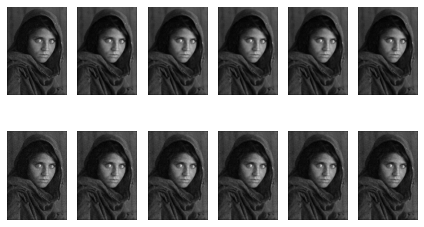

afghan1, afghan2
Original grayscale image & Filtered with guidance filter I = grayscale, r, g, b, rgb
start from left


In [261]:
fig, ax = plt.subplots(2, 6)

ax[0][0].imshow(img1_grayscale, cmap='gray')
ax[0][0].axis('off')
ax[0][1].imshow(smoothed_img1_withGray, cmap='gray')
ax[0][1].axis('off')
ax[0][2].imshow(smoothed_img1_withR, cmap='gray')
ax[0][2].axis('off')
ax[0][3].imshow(smoothed_img1_withG, cmap='gray')
ax[0][3].axis('off')
ax[0][4].imshow(smoothed_img1_withB, cmap='gray')
ax[0][4].axis('off')
ax[0][5].imshow(smoothed_img1_withRGB, cmap='gray')
ax[0][5].axis('off')

ax[1][0].imshow(img2_grayscale, cmap='gray')
ax[1][0].axis('off')
ax[1][1].imshow(smoothed_img2_withGray, cmap='gray')
ax[1][1].axis('off')
ax[1][2].imshow(smoothed_img2_withR, cmap='gray')
ax[1][2].axis('off')
ax[1][3].imshow(smoothed_img2_withG, cmap='gray')
ax[1][3].axis('off')
ax[1][4].imshow(smoothed_img2_withB, cmap='gray')
ax[1][4].axis('off')
ax[1][5].imshow(smoothed_img2_withRGB, cmap='gray')
ax[1][5].axis('off')

fig.tight_layout()
plt.show()
print("afghan1, afghan2")
print("Original grayscale image & Filtered with guidance filter I = grayscale, r, g, b, rgb")
print("start from left")

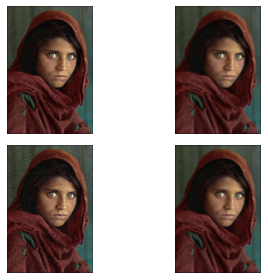

afghan1, afghan2
Original color image & Filtered with guidance filter I = grayscale
start from left


In [262]:
fig, ax = plt.subplots(2, 2)

ax[0][0].imshow(img1)
ax[0][0].axis('off')
ax[0][1].imshow(smoothed_img1)
ax[0][1].axis('off')

ax[1][0].imshow(img2)
ax[1][0].axis('off')
ax[1][1].imshow(smoothed_img2)
ax[1][1].axis('off')

fig.tight_layout()
plt.show()

print("afghan1, afghan2")
print("Original color image & Filtered with guidance filter I = grayscale")
print("start from left")

#### Best Result with Single Channel input, output

For afghan1:

using all 3 RGB channel as guidance in (r=2, sig=1, eps=0.05)

PSNR increased about 20% (28.4 -> 34.1)

For afghan2:

using G channel as guidance in (r=2, sig=1, eps=0.05)

PSNR increased about 42% (22.8 -> 32.3)

run time was all 7~10 seconds

### How to improve performance or enhance runtime
Filter2D algorithm used in f_mean is currently calculates sequentially through pixels

It can be improved when calculation is done simultaneously (such as using GPUs or multithread on CPU)

## Problem 2 Weighted Median Filter

#### Weighted Median Filter Algorithm for pre-defined kernel
(Ex. box filter, gaussian filter)

In [115]:
def WMF(img, kernel):
    filtered_img = np.zeros(img.shape)
    k_h, k_w = kernel.shape
    pad_img = np.pad(img, ((int(k_h/2), int(k_h/2)), (int(k_w/2), int(k_w/2))))
    kernel_flatten = kernel.flatten()
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            window_flatten = pad_img[i:i+k_h, j:j+k_w].flatten()
            window_flatten_argsort = np.argsort(window_flatten)
            weight = [kernel_flatten[e] for e in window_flatten_argsort]
            s = 0
            for idx, w in enumerate(weight):
                s += w
                if(s >= 0.5):
                    break
            filtered_img[i,j] = window_flatten[window_flatten_argsort[idx]]
    return filtered_img

#### Bilateral Median Filter Algorithm

In [228]:
def getBilateralFilter(window, sig_s, sig_r):
    size = window.shape[0]
    center = window[int((size-1)/2)][int((size-1)/2)]
    kernel = np.fromfunction(lambda x, y: math.e ** ((-1*((x-(size-1)/2)**2+(y-(size-1)/2)**2))/(2*sig_s**2) + (-1*((window-center)**2)/(2*sig_r**2))), window.shape)
    kernel /= np.sum(kernel)
    return kernel
    
def Bilateral_WMF(img, kernel_size, sig_s, sig_r):
    filtered_img = np.zeros(img.shape)
    k_h, k_w = kernel_size
    pad_img = np.pad(img, ((int(k_h/2), int(k_h/2)), (int(k_w/2), int(k_w/2))))
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            window = pad_img[i:i+k_h, j:j+k_w]
            kernel = getBilateralFilter(window, sig_s, sig_r)
            kernel_flatten = kernel.flatten()
            window_flatten = window.flatten()
            window_flatten_argsort = np.argsort(window_flatten)
            weight = [kernel_flatten[e] for e in window_flatten_argsort]
            s = 0
            for idx, w in enumerate(weight):
                s += w
                if(s >= 0.5):
                    break
            filtered_img[i,j] = window_flatten[window_flatten_argsort[idx]]
    return filtered_img

### Test

In [270]:
### Set IMAGES ###
### Change Scale from 0~255 to 0~1 ###
img1 = cv2.cvtColor(cv2.imread('monkey_noise1.png'), cv2.COLOR_BGR2RGB)/255
img2 = cv2.cvtColor(cv2.imread('monkey_noise2.png'), cv2.COLOR_BGR2RGB)/255

clean_img = cv2.cvtColor(cv2.imread('monkey_clean.png'), cv2.COLOR_BGR2RGB)/255

img1_grayscale = np.sum(img1, 2)/3
img2_grayscale = np.sum(img2, 2)/3
clean_grayscale = np.sum(clean_img, 2)/3

#### BoxFilter Weighted Median Filter

In [271]:
print("Smooth monkey_noise1 with boxfilter r=2,4,8")
kernel = np.zeros((5,5)) + 1
kernel /= np.sum(kernel)
start = time.time()
smoothed_img1_withBox2 = WMF(img1_grayscale, kernel)
run_time = time.time() - start
showTestResult(smoothed_img1_withBox2, clean_grayscale, img1_grayscale, run_time, "r=2")

kernel = np.zeros((9,9)) + 1
kernel /= np.sum(kernel)
start = time.time()
smoothed_img1_withBox4 = WMF(img1_grayscale, kernel)
run_time = time.time() - start
showTestResult(smoothed_img1_withBox4, clean_grayscale, img1_grayscale, run_time, "r=4")

kernel = np.zeros((17,17)) + 1
kernel /= np.sum(kernel)
start = time.time()
smoothed_img1_withBox8 = WMF(img1_grayscale, kernel)
run_time = time.time() - start
showTestResult(smoothed_img1_withBox8, clean_grayscale, img1_grayscale, run_time, "r=8")

print("Smooth monkey_noise2 with boxfilter r=2,4,8")
kernel = np.zeros((5,5)) + 1
kernel /= np.sum(kernel)
start = time.time()
smoothed_img2_withBox2 = WMF(img2_grayscale, kernel)
run_time = time.time() - start
showTestResult(smoothed_img2_withBox2, clean_grayscale, img2_grayscale, run_time, "r=2")

kernel = np.zeros((9,9)) + 1
kernel /= np.sum(kernel)
start = time.time()
smoothed_img2_withBox4 = WMF(img2_grayscale, kernel)
run_time = time.time() - start
showTestResult(smoothed_img2_withBox4, clean_grayscale, img2_grayscale, run_time, "r=4")

kernel = np.zeros((17,17)) + 1
kernel /= np.sum(kernel)
start = time.time()
smoothed_img2_withBox8 = WMF(img2_grayscale, kernel)
run_time = time.time() - start
showTestResult(smoothed_img2_withBox8, clean_grayscale, img2_grayscale, run_time, "r=8")

Smooth monkey_noise1 with boxfilter r=2,4,8
---------------------------------------------------
r=2
run time was 3.2510805130004883
기존 PSNR: 22.297180007296156
smoothed PSNR: 23.704309674869435
---------------------------------------------------
---------------------------------------------------
r=4
run time was 5.226477146148682
기존 PSNR: 22.297180007296156
smoothed PSNR: 22.371969939805425
---------------------------------------------------
---------------------------------------------------
r=8
run time was 17.394080638885498
기존 PSNR: 22.297180007296156
smoothed PSNR: 21.039188828378098
---------------------------------------------------
Smooth monkey_noise2 with boxfilter r=2,4,8
---------------------------------------------------
r=2
run time was 4.917168617248535
기존 PSNR: 18.4421249335672
smoothed PSNR: 23.628074588345925
---------------------------------------------------
---------------------------------------------------
r=4
run time was 7.154860019683838
기존 PSNR: 18.442124933

#### Gaussian Filter Weighted Median Filter

In [272]:
print("Smooth monkey_noise1 with Gaussianfilter r=2,4,8")
kernel = getGaussianFilter(2,1)
start = time.time()
smoothed_img1_withGaussian2 = WMF(img1_grayscale, kernel)
run_time = time.time() - start
showTestResult(smoothed_img1_withGaussian2, clean_grayscale, img1_grayscale, run_time, "r=2")

kernel = getGaussianFilter(4,1)
start = time.time()
smoothed_img1_withGaussian4 = WMF(img1_grayscale, kernel)
run_time = time.time() - start
showTestResult(smoothed_img1_withGaussian4, clean_grayscale, img1_grayscale, run_time, "r=4")

kernel = getGaussianFilter(8,1)
start = time.time()
smoothed_img1_withGaussian8 = WMF(img1_grayscale, kernel)
run_time = time.time() - start
showTestResult(smoothed_img1_withGaussian8, clean_grayscale, img1_grayscale, run_time, "r=8")

print("Smooth monkey_noise2 with Gaussianfilter r=2,4,8")
kernel = getGaussianFilter(2,1)
start = time.time()
smoothed_img2_withGaussian2 = WMF(img2_grayscale, kernel)
run_time = time.time() - start
showTestResult(smoothed_img2_withGaussian2, clean_grayscale, img2_grayscale, run_time, "r=2")

kernel = getGaussianFilter(4,1)
start = time.time()
smoothed_img2_withGaussian4 = WMF(img2_grayscale, kernel)
run_time = time.time() - start
showTestResult(smoothed_img2_withGaussian4, clean_grayscale, img2_grayscale, run_time, "r=4")

kernel = getGaussianFilter(8,1)
start = time.time()
smoothed_img2_withGaussian8 = WMF(img2_grayscale, kernel)
run_time = time.time() - start
showTestResult(smoothed_img2_withGaussian8, clean_grayscale, img2_grayscale, run_time, "r=8")

Smooth monkey_noise1 with Gaussianfilter r=2,4,8
---------------------------------------------------
r=2
run time was 2.114910364151001
기존 PSNR: 22.297180007296156
smoothed PSNR: 26.674220042605604
---------------------------------------------------
---------------------------------------------------
r=4
run time was 4.054627180099487
기존 PSNR: 22.297180007296156
smoothed PSNR: 26.655091506767356
---------------------------------------------------
---------------------------------------------------
r=8
run time was 12.790035724639893
기존 PSNR: 22.297180007296156
smoothed PSNR: 26.655029704931525
---------------------------------------------------
Smooth monkey_noise2 with Gaussianfilter r=2,4,8
---------------------------------------------------
r=2
run time was 2.0818848609924316
기존 PSNR: 18.4421249335672
smoothed PSNR: 26.499170611675297
---------------------------------------------------
---------------------------------------------------
r=4
run time was 5.3851706981658936
기존 PSNR: 1

#### Bilateral Filter Weighted Median Filter

In [277]:
print("Smooth monkey_noise1 with Bilateralfilter r=2,4,8")
start = time.time()
smoothed_img1_withBilateral2 = Bilateral_WMF(img1_grayscale, (5,5), 100, 100)
run_time = time.time() - start
showTestResult(smoothed_img1_withBilateral2, clean_grayscale, img1_grayscale, run_time, "r=2")

start = time.time()
smoothed_img1_withBilateral4 = Bilateral_WMF(img1_grayscale, (9,9), 100, 100)
run_time = time.time() - start
showTestResult(smoothed_img1_withBilateral4, clean_grayscale, img1_grayscale, run_time, "r=4")

start = time.time()
smoothed_img1_withBilateral8 = Bilateral_WMF(img1_grayscale, (17,17), 100, 100)
run_time = time.time() - start
showTestResult(smoothed_img1_withBilateral8, clean_grayscale, img1_grayscale, run_time, "r=8")

print("Smooth monkey_noise2 with Bilateralfilter r=2,4,8")
start = time.time()
smoothed_img2_withBilateral2 = Bilateral_WMF(img2_grayscale, (5,5), 100, 100)
run_time = time.time() - start
showTestResult(smoothed_img2_withBilateral2, clean_grayscale, img2_grayscale, run_time, "r=2")

start = time.time()
smoothed_img2_withBilateral4 = Bilateral_WMF(img2_grayscale, (9,9), 100, 100)
run_time = time.time() - start
showTestResult(smoothed_img2_withBilateral4, clean_grayscale, img2_grayscale, run_time, "r=4")

start = time.time()
smoothed_img2_withBilateral8 = Bilateral_WMF(img2_grayscale, (17,17), 100, 100)
run_time = time.time() - start
showTestResult(smoothed_img2_withBilateral8, clean_grayscale, img2_grayscale, run_time, "r=8")

Smooth monkey_noise1 with Bilateralfilter r=2,4,8
---------------------------------------------------
r=2
run time was 5.344353199005127
기존 PSNR: 22.297180007296156
smoothed PSNR: 23.704309674869435
---------------------------------------------------
---------------------------------------------------
r=4
run time was 7.290171384811401
기존 PSNR: 22.297180007296156
smoothed PSNR: 22.371969939805425
---------------------------------------------------
---------------------------------------------------
r=8
run time was 18.867663383483887
기존 PSNR: 22.297180007296156
smoothed PSNR: 21.039188828378098
---------------------------------------------------
Smooth monkey_noise2 with Bilateralfilter r=2,4,8
---------------------------------------------------
r=2
run time was 6.221836805343628
기존 PSNR: 18.4421249335672
smoothed PSNR: 23.628074588345925
---------------------------------------------------
---------------------------------------------------
r=4
run time was 9.073758125305176
기존 PSNR: 1

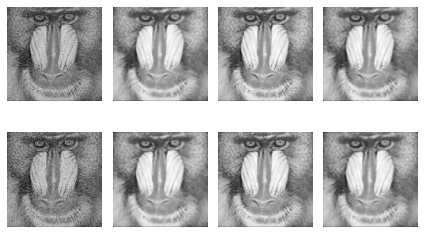

monkey1, monkey2
Original grayscale image & Filtered with WMF W (2x2) = BoxFilter, Gaussian, Bilateral
start from left


In [278]:
fig, ax = plt.subplots(2, 4)

ax[0][0].imshow(img1_grayscale, cmap='gray')
ax[0][0].axis('off')
ax[0][1].imshow(smoothed_img1_withBox2, cmap='gray')
ax[0][1].axis('off')
ax[0][2].imshow(smoothed_img1_withGaussian2, cmap='gray')
ax[0][2].axis('off')
ax[0][3].imshow(smoothed_img1_withBilateral2, cmap='gray')
ax[0][3].axis('off')

ax[1][0].imshow(img2_grayscale, cmap='gray')
ax[1][0].axis('off')
ax[1][1].imshow(smoothed_img2_withBox2, cmap='gray')
ax[1][1].axis('off')
ax[1][2].imshow(smoothed_img2_withGaussian2, cmap='gray')
ax[1][2].axis('off')
ax[1][3].imshow(smoothed_img2_withBilateral2, cmap='gray')
ax[1][3].axis('off')

fig.tight_layout()
plt.show()
print("monkey1, monkey2")
print("Original grayscale image & Filtered with WMF W (2x2) = BoxFilter, Gaussian, Bilateral")
print("start from left")

#### Best Result

Quantatively (comparing PSNR):

For monkey1:

r=4 gaussian filter, 19% (22.29 -> 26.65)

For monkey2:

r=4 gaussian filter, 44% (18.44 -> 26.48)

Qualitively (comparing with human eye):

Bilateral Filters and Gaussian seems similar(nice sharp edge, smooth surface)

### How to improve performance or enhance runtime
run time is to high for larger kernels

bottleneck is sorting

not sorting single window every time, save the order of adjacent pixels and use Repeatedly 